In [1]:
# Import libraries
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset with added essays from ChatGPT and BARD.
df = pd.read_csv('/kaggle/input/more-essays-csv/merged_essays.csv')

In [3]:
# Display dataset
print(df.head())

         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3    940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  


In [4]:
# Specify the features (X) and target variable (y)
X = df
Y = df['generated']

In [5]:
# Split the dataset into training and test sets - 70:30 ratio
X_train, X_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.3, random_state=42)


In [6]:
# Display the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Development set shape:", X_dev.shape, y_dev.shape)

Training set shape: (1041, 4) (1041,)
Development set shape: (447, 4) (447,)


In [7]:
from collections import Counter
from collections import defaultdict

my_dictionary= {}
no_of_human_documents = 0
no_of_llm_documents = 0

In [8]:
'''
build_vocabulary : This function builds a vocabulary by counting the occurrences of each word,
then filters out words that occur fewer times than the specified min_occurrence threshold i.e.,
5. And utilizes the Counter class from the collections module to count word occurrences.
'''
def build_vocabulary(essay, min_occurrence=5):

    # Flatten the list of sentences into a single list of words
    all_words = [word.lower() for word in essay.split()]

    # Count the occurrences of each word
    word_counts = Counter(all_words)

    # Filter out rare words based on the minimum occurrence threshold
    '''
    a dictionary comprehension that creates a new dictionary named vocabulary where each entry 
    consists of words and their counts from the word_counts dictionary, but only includes 
    those words where their count meets or exceeds the specified threshold min_occurrence.
    '''
    vocabulary = {word : count for word, count in word_counts.items() if count >= min_occurrence}
    
    return vocabulary

In [9]:
for index,row in X_train.iterrows():
  vocabulary = build_vocabulary(row['text'])
  if(row['generated'] == 0):
    no_of_human_documents += 1
    Class_voc={'HUMAN':0}
    Class_voc.update(vocabulary)
  else:
    no_of_llm_documents += 1
    Class_voc={'LLM':1}
    Class_voc.update(vocabulary)
  try:
    my_dictionary[row['id']].append(Class_voc)
  except KeyError:
    my_dictionary = {**my_dictionary, **{row['id']: Class_voc}}

print(dict(list(my_dictionary.items())[0:10]))

{'eafb8a56': {'LLM': 1, 'car': 5, 'to': 5, 'of': 6, 'the': 8, 'our': 5, 'a': 6, 'be': 5, 'for': 5, 'and': 6, 'it': 5}, 'aa0b24ef': {'HUMAN': 0, 'there': 5, 'or': 7, 'not': 7, 'we': 5, 'the': 54, 'electoral': 13, 'have': 7, 'it': 6, 'and': 7, 'vote': 7, 'on': 5, 'i': 5, 'is': 10, 'to': 25, 'election': 5, 'for': 9, 'of': 17, 'if': 6, 'system': 5, 'would': 11, 'people': 7, 'feel': 6, 'their': 15, 'votes': 6, 'matter': 5, 'more': 5, 'they': 10, 'electors': 6, 'that': 16, 'in': 12, 'are': 8, 'you': 9, 'your': 5, 'states': 7, 'candidates': 5, 'were': 6, 'because': 5, 'votes.': 5}, 'b9229a95': {'HUMAN': 0, 'in': 15, 'the': 36, 'electoral': 11, 'college': 10, ',': 9, 'popular': 6, 'vote': 11, 'would': 7, 'be': 6, 'a': 19, 'chance': 5, 'for': 9, 'to': 13, 'voice': 5, 'is': 5, 'how': 6, 'voters': 6, 'and': 5, 'of': 7, 'tie': 6, 'then': 5, 'paragraph': 5, 'it': 5, 'that': 6, 'president': 7, 'electors': 5, 'who': 5, 'thats': 5, 'we': 6, 'have': 8}, 'e5dcf622': {'HUMAN': 0, 'not': 10, 'the': 45, 'e

In [10]:
'''
This function counts the number of documents in which the given word appears and the 
probability is computed as the ratio of the number of documents containing the word to the 
total number of documents. 
P[“the”] = no of documents containing ‘the’ / no of all documents
'''
def calculate_probability(word, documents):
    num_documents_with_word = sum(1 for document in documents.values() if word in document)
    # Calculate the probability
    probability = num_documents_with_word / len(X_train)
    return probability


'''
This function counts the number of documents in the specified class and counts the number of 
documents in the specified class that contain the given word. Finally, probability of the word
occurring in a document given that the document belongs to the specified class. 
P[“the” | LLM] = no of LLM documents containing “the” / no of all LLM documents
'''
def calculate_conditional_probability(word, documents,class_label):
    num_documents_in_class=0
    num_positive_documents=0
    for document in documents.values():
      if(word in document and list(document.items())[0][0]==class_label):
        num_positive_documents=num_positive_documents+1
      if(list(document.items())[0][0]==class_label):
        num_documents_in_class=num_documents_in_class+1
    probability = num_positive_documents / num_documents_in_class
    return probability

In [11]:
# Word for class probability is calculated
target_word = "the"
class_label = "LLM"
# Calculate the probability of the word
probability = calculate_probability(target_word, my_dictionary)
llm_conditional_probability = calculate_conditional_probability(target_word, my_dictionary,class_label)

# Display the result
print(f"Probability of '{target_word}': {probability:.4f}")
print(f"Probability of '{target_word} in {class_label} class ': {llm_conditional_probability:.4f}")

Probability of 'the': 0.9817
Probability of 'the in LLM class ': 0.9024


In [12]:
import math

X_train_data = X_train[['text','generated']].values.tolist()
X_dev_data=X_dev[['text','generated']].values.tolist()
# print (X_dev_data[:5])

In [13]:
def tokenize(text):
    return nltk.word_tokenize(text.lower())

In [14]:
'''
This function tokenizes the text using the tokenize function and counts the occurrences of 
each word followed by the count of each word in the vocabulary for the respective class and 
counts the number of essays for each class.
input data has text (essay text), generated (generated key)
'''
def count_words(data):
  word_counts = defaultdict(int)
  class_counts = defaultdict(int)

    # Iterate through each entry in the dataset
  for text, label in data:
    words = tokenize(text)

    words_counts = Counter(words)
    min_occurrence = 5

    # Filter out rare words based on the minimum occurrence threshold
    vocabulary = [word  for word,count in words_counts.items() if count >= min_occurrence]

    # Calculating number of essays of each class
    class_counts[label] += 1

    # Count of each word with respective of that class
    for word in vocabulary:
      word_counts[(word, label)] += 1
  
  return word_counts, class_counts

'''
This function calculates the probabilities of each word given its class
'''
def calculate_probabilities(word_counts, class_counts ,smoothing=0.2):
    
    #calculate the number of unique words in the word_counts dictionary
    vocabulary_size = len(set(word for word, _ in word_counts.keys()))
    # print ("vocab size is ", vocabulary_size) #783
    probabilities = defaultdict(int)
    
    for (word, label), count in word_counts.items():
        prob_word_given_class = ((count + smoothing) / (class_counts[label] + smoothing * vocabulary_size))
        log_prob_word_given_class = math.log(prob_word_given_class)
        probabilities[(word, label)] = log_prob_word_given_class
        
    return probabilities

'''
This function is used to multiply the probabilities of all words for each class and adjusts 
the probabilities based on the prior probabilities of each class. Finally, compares the each 
class probabilities and predicts the class based on higher probability.
'''
def predict_class(text,probabilities, class_count,smoothing):
  words = tokenize(text)
  log_prob_human = 1
  log_prob_llm = 1
  for word in words:
        log_prob_human *= probabilities.get((word, 0), smoothing )
        log_prob_llm *= probabilities.get((word, 1), smoothing )

  log_prob_human *= math.log(class_count[0]/(class_count[0]+class_count[1]))
  log_prob_llm *= math.log(class_count[1]/(class_count[0]+class_count[1]))

  final_prob_human = log_prob_human / (log_prob_human + log_prob_llm)
  final_prob_llm = log_prob_llm / (log_prob_human + log_prob_llm)

  return 0 if final_prob_human >= final_prob_llm else 1

'''
This function compares the predicted class with the true label and counts correct predictions.
'''
def evaluate_accuracy(dev_data, probabilities, class_count,smoothing=0.2):
    correct_predictions = 0

    for text, true_label in dev_data:
        predicted_label = predict_class(text, probabilities, class_count,smoothing)
        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / len(dev_data)
    return accuracy

In [15]:
words_count,class_count = (count_words(X_train_data))
# print('Class 0 is HUMAN \nClass 1 is LLM')
# print('\nWords count ("word","class" ==> count) : ',words_count)
# print('Class Count ("class" ==> count) : ',class_count)

probabilities_of_each_word = calculate_probabilities(words_count, class_count)
# print('\nProbability of word in that particular class ("word","class" ==> probability) : ',probabilities_of_each_word)

accuracy = evaluate_accuracy(X_dev_data
                             , probabilities_of_each_word, class_count)
print(f"\nAccuracy on dev data: {accuracy}")


Accuracy on dev data: 0.8926174496644296


In [16]:
def derive_top_words(probabilities, label, top_n=10):
    words_prob = [(word, prob) for (word, l), prob in probabilities.items() if l == label]
    words_prob.sort(key=lambda x: x[1], reverse=True)
    return words_prob[:top_n]



def apply_smoothing(train_data, dev_data,smoothing_values):

    for smoothing in smoothing_values:
        word_counts, class_counts = count_words(train_data)
        class_probabilities = {label: count / len(train_data) for label, count in class_counts.items()}
        probabilities = calculate_probabilities(word_counts, class_counts, smoothing)

        accuracy = evaluate_accuracy(dev_data, probabilities, class_probabilities,smoothing)
        all_accuracy.append(accuracy)
        print(f"\nAccuracy on dev data with smoothing {smoothing}: {accuracy}")

In [17]:
all_accuracy = []
smoothing_values = [0.2, 0.3, 0.4, 0.5]
apply_smoothing(X_train_data, X_dev_data,smoothing_values)

top_words_human = derive_top_words(probabilities_of_each_word, 0)
top_words_llm = derive_top_words(probabilities_of_each_word, 1)

print("\nTop 10 words predicting human essays:")
for word, prob in top_words_human:
    print(f"{word}: {prob}")

print("\nTop 10 words predicting LLM-generated essays:")
for word, prob in top_words_llm:
    print(f"{word}: {prob}")


Accuracy on dev data with smoothing 0.2: 0.8926174496644296

Accuracy on dev data with smoothing 0.3: 0.7628635346756152

Accuracy on dev data with smoothing 0.4: 0.6577181208053692

Accuracy on dev data with smoothing 0.5: 0.5727069351230425

Top 10 words predicting human essays:
.: -0.15104805204002933
the: -0.15942331037676163
of: -0.16786930653017254
to: -0.17318450985897604
,: -0.18282365485707963
a: -0.1925566180319656
in: -0.20899174199395146
and: -0.21120364291788143
is: -0.31371417384481864
that: -0.42932219677309835

Top 10 words predicting LLM-generated essays:
the: -1.168024359490481
,: -1.18159308869655
.: -1.267115262134712
and: -1.267115262134712
of: -1.2973290407312086
a: -1.4109031549264237
to: -1.7809215140388404
electoral: -2.2479445151464383
in: -2.2479445151464383
college: -2.420787327985849


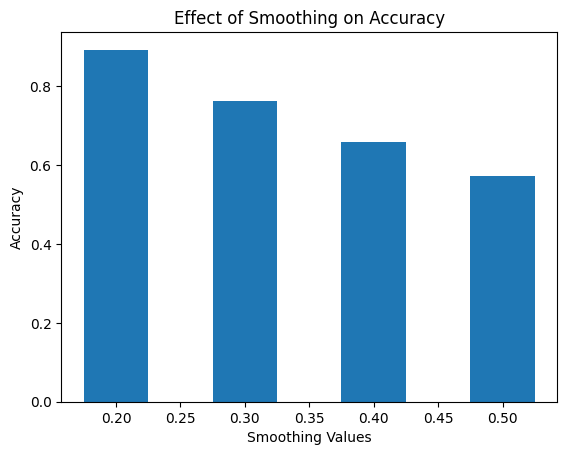

In [18]:
from matplotlib import pyplot as plt
plt.bar(smoothing_values, all_accuracy,width=0.05)
plt.xlabel('Smoothing Values')
plt.ylabel('Accuracy')
plt.title('Effect of Smoothing on Accuracy')
plt.show()